# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# import libraries
import re
import numpy as np
import pandas as pd
import pickle

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sqlalchemy import create_engine

import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download(['punkt', 'wordnet'])

[nltk_data] Downloading package punkt to /home/ambreen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ambreen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.1.


In [6]:
local = 1
if local:
  db_path = 'sqlite:///data/DisasterResponse.db'
else:
  #content/drive/My Drive/Udacity/Disaster_Response_Pipeline_Project/data/DisasterResponse.db
  db_path = 'sqlite:///drive/My Drive/Udacity/Disaster_Response_Pipeline_Project/data/DisasterResponse.db'

In [7]:
# load data from database
engine = create_engine(db_path)
df = pd.read_sql('select * from Messages', engine)
df.drop(columns = ['id', 'original'], inplace = True)
X = df[['message', 'genre']]
Y = df.loc[:, ~df.columns.isin(X.columns)]
display(X.columns)
display(Y.columns)

Index(['message', 'genre'], dtype='object')

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

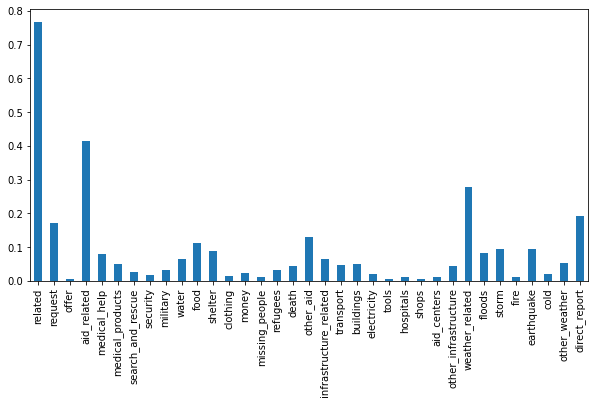

In [8]:
(Y.sum()/Y.shape[0]).plot(kind='bar', figsize = (10, 5))

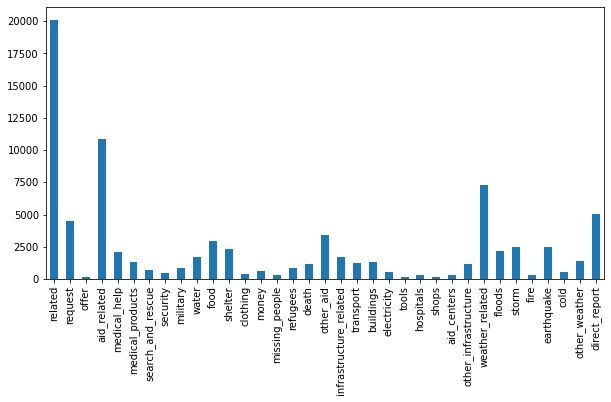

In [9]:
Y.sum().plot(kind='bar', figsize = (10, 5))

In [10]:
df.loc[df.related == 1, 'message'].values

array(['Weather update - a cold front from Cuba that could pass over Haiti',
       'Is the Hurricane over or is it not over',
       'Looking for someone but no name', ...,
       "Proshika, operating in Cox's Bazar municipality and 5 other unions, Ramu and Chokoria, assessment, 5 kg rice, 1,5 kg lentils to 700 families.",
       'Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       'A radical shift in thinking came about as a result of this meeting, recognizing that HIV/AIDS is at the core of the humanitarian crisis and identifying the crisis itself as a function of the HIV/AIDS pandemic.'],
      dtype=object)

### 2. Write a tokenization function to process your text data

In [10]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, 'urlplaceholder', text)    
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(x).lower().strip() for x in tokens]
    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [0]:
pipeline1 = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultiOutputClassifier(AdaBoostClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [11]:
X_msg = X['message']
X_train, X_test, y_train, y_test = train_test_split(X_msg, Y)

In [14]:
pipeline1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7f74dd60a7b8>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='S

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [0]:
y_pred1 = pipeline1.predict(X_test)

In [12]:
def labeled_classification_report(y, y_pred):
    '''display output of classification_report for each label'''
    cols = y.columns.values
    for i in range(0, len(cols)):
        print(f'{cols[i]}')
        print('-'*55)
        c_pred = y_pred1[:,i]
        c_true = y[cols[i]]
        print(classification_report(c_true, c_pred))


In [13]:
def recall_f1_auc(y_true, predicted):
    '''Calculates recall, f1, and auc scores'''
    
    f1 = f1_score(y_test, predicted, average = 'macro')
    auc = roc_auc_score(y_true, predicted, multi_class = 'ovo', average ='macro')
    recall = recall_score(y_true, predicted, average = 'macro')
    return f1, auc, recall

In [14]:
def display_scores(y_true, predicted):
    '''Display f-1, recall, and AUC scores'''
    
    f1, auc, recall = recall_f1_auc(y_true, predicted)
    display('======================')
    display(f'recall score: {recall}')
    display(f'f1 score: {f1}')
    display(f'AUC score: {auc}')
    display('======================')


In [19]:
labeled_classification_report(y_test, y_pred1)

related
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.34      0.44      1570
           1       0.82      0.94      0.87      4984

    accuracy                           0.79      6554
   macro avg       0.72      0.64      0.66      6554
weighted avg       0.77      0.79      0.77      6554

request
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5465
           1       0.78      0.55      0.65      1089

    accuracy                           0.90      6554
   macro avg       0.85      0.76      0.79      6554
weighted avg       0.89      0.90      0.89      6554

offer
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6523
           1       0.00      0.00      0.00    

In [20]:
display_scores(y_test.values, y_pred1)

'======================'

'recall score: 0.34025104915931625'

'f1 score: 0.41292866170390474'

'AUC score: 0.6541710367744484'

'======================'

### 6. Improve your model
Use grid search to find better parameters. 

In [0]:
def evaluate_classifiers():
    """Evaluate different classifiers with default settings"""

    vect = CountVectorizer(tokenizer = tokenize)
    tfidf = TfidfTransformer()
    y_true = y_test.values
    perf = []
    y_preds_all = dict()
    score_names = ['f-1', 'AUC', 'recall']
    
    candidates = [
        ['XGBoost', MultiOutputClassifier(XGBClassifier(scale_pos_weight=10))],
        ['AdaBoost', MultiOutputClassifier(AdaBoostClassifier())],
        ['RandomForest', RandomForestClassifier()],
        ['ExtraTreesClassifier', ExtraTreesClassifier()],
    ]

    for i in range(len(candidates)):
        p = Pipeline([
            ('vect', vect),
            ('tfidf', tfidf),
            ('classifier', candidates[i][1])
        ])
    
        candidates[i][1] = p.fit(X_train, y_train)
        pred = p.predict(X_test)
        y_preds_all[candidates[i][0]] = pred
        f1, auc, recall = recall_f1_auc(y_true, pred)
        perf.append([f1, auc, recall])
    
    return score_names, perf, candidates

In [0]:
score_names, perf, candidates = evaluate_classifiers()

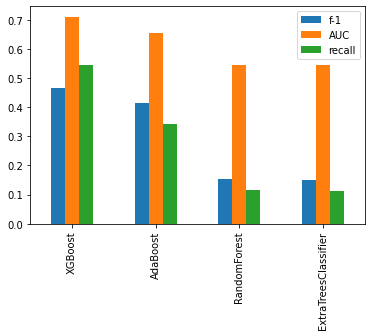

In [32]:
import matplotlib.pyplot as plt

score_df = pd.DataFrame(perf, columns = score_names, index = list(map(lambda x:  x[0], candidates)))
score_df.plot(kind = 'bar')

In [33]:
score_df

,f-1,AUC,recall
XGBoost,0.466564,0.710436,0.545243
AdaBoost,0.412929,0.654171,0.340251
RandomForest,0.152861,0.546069,0.115454
ExtraTreesClassifier,0.149802,0.544823,0.110879


Looks like XGBoost has better score overall.

In [15]:
selected_pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultiOutputClassifier(XGBClassifier()))
])

In [16]:
selected_pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x7f1d80f950e0>)),
  ('tfidf', TfidfTransformer()),
  ('classifier',
   MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None, gamma=None,
                                                 gpu_id=None,
                                                 importance_type='gain',
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 min_child_weight=None,
                                            

In [17]:
def get_best_classifier(selected_pipeline, parameters):

    cv = GridSearchCV(selected_pipeline, 
                      param_grid = parameters, 
                      verbose = 2, n_jobs = 8,
                      scoring = ['recall_macro', 'f1_macro'], 
                      refit = 'recall_macro')
    return cv

In [18]:
parameters = {
    'classifier__estimator__scale_pos_weight':[5, 10, 20, 100],
    'classifier__estimator__learning_rate': [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    'tfidf__use_idf': [True, False],
    }

cv = get_best_classifier(selected_pipeline, parameters)

In [19]:
%%time

cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 53.6min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 273.1min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 428.8min finished


CPU times: user 32min 16s, sys: 1min 21s, total: 33min 38s
Wall time: 7h 13min 11s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7f1d80f950e0>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                                                      booster=None,
                                                                                      colsample_bylevel=None,
                                                                                      colsample_bynode=None,
                                                                                      colsample_bytree=None,
                                                                                      gamma=None,
                                                                                      gpu_id

In [20]:
cv.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7f1d80f950e0>)),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('classifier',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               importance_type='gain',
                                                               interaction_constraints=None,
                                                     

In [21]:
cv.best_params_

{'classifier__estimator__learning_rate': 0.1,
 'classifier__estimator__scale_pos_weight': 100,
 'tfidf__use_idf': False}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [23]:
y_pred2 = cv.predict(X_test)

In [24]:
display_scores(y_test.values, y_pred2)

'======================'

'recall score: 0.7223810428341978'

'f1 score: 0.2591083141214426'

'AUC score: 0.6554076162938897'

'======================'

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [25]:
class LengthExtractor(BaseEstimator, TransformerMixin):
    '''Length exrtactor custom transformer'''
    def length(self, text):
        return len(text)

    def fit(self, x, y = None):
        return self
    
    def transform(self, X):
        len_list = pd.Series(X).apply(self.length)
        return pd.DataFrame(len_list)

In [26]:
vect = CountVectorizer(tokenizer = tokenize)
tfidf = TfidfTransformer()

pipeline_extended = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vect', vect),
            ('tfidf', tfidf)
        ])),
        ('length', LengthExtractor())
    ])),
    ('classifier', MultiOutputClassifier(XGBClassifier(learning_rate =  0.1, scale_pos_weight = 100)))
])

In [27]:
pipeline_extended.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x7f1d80f950e0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('length',
                                                 LengthExtractor())])),
                ('classifier',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=Non...
                                                 

In [28]:
pred_extended = pipeline_extended.predict(X_test)

In [29]:
display_scores(y_test.values, pred_extended)

'======================'

'recall score: 0.7160603774636203'

'f1 score: 0.260001465943571'

'AUC score: 0.6559797063125958'

'======================'

In [0]:
pipeline_extended.get_params()

{'memory': None,
 'steps': [('features', FeatureUnion(transformer_list=[('text',
                                   Pipeline(steps=[('vect',
                                                    CountVectorizer(tokenizer=<function tokenize at 0x7f8e8298ddd0>)),
                                                   ('tfidf',
                                                    TfidfTransformer())])),
                                  ('length', LengthExtractor())])),
  ('classifier', MultiOutputClassifier(estimator=AdaBoostClassifier()))],
 'verbose': False,
 'features': FeatureUnion(transformer_list=[('text',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(tokenizer=<function tokenize at 0x7f8e8298ddd0>)),
                                                 ('tfidf',
                                                  TfidfTransformer())])),
                                ('length', LengthExtractor())]),
 'classifier': M

In [0]:
parameters = {
    'classifier__estimator__learning_rate': [0.00001, 0.000001, 0.2, 0.4, 0.6, 0.8, 1],
    'features__text__tfidf__use_idf': [True, False],
    'classifier__estimator__algorithm':['SAMME', 'SAMME.R'],
    'classifier__estimator__n_estimators': [5, 10, 15, 20, 30, 40, 50],
    }
cv2 = get_best_classifier(pipeline_extended, parameters)

In [0]:
cv2.fit(X_train, y_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 84.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 147.0min
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed: 226.8min finished


GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x7f8e8298ddd0>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())])),
                                                                       ('length',
                                                                        LengthExtractor())])),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier()))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__al

In [0]:
pred_ext = cv2.predict(X_test)

In [0]:
display_scores(y_test.values, pred_ext)

'f1-score: 0.6153685580320022'

'AUC score: 0.6845988517837202'

### 9. Export your model as a pickle file

In [22]:
s = pickle.dump(cv, open('models/classifier_xgboost.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.